<a href="https://colab.research.google.com/github/bryanmcelvy/4308_real_time_eeg/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time Seizure Classification Model

#### Imports

##### Import libraries

In [ ]:
''' Import libraries'''
# Built-in Python libraries
import os
import sys

# Custom Functions/Classes
if '/content/4308_real_time_eeg' not in sys.path:
  !git clone https://github.com/bryanmcelvy/4308_real_time_eeg.git
  sys.path.append('/content/4308_real_time_eeg')

from feature_extraction import *
from log_reg_funcs import *

# 3rd-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

Cloning into '4308_real_time_eeg'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 84 (delta 10), reused 12 (delta 4), pack-reused 65
Unpacking objects: 100% (84/84), done.


##### Import dataset

In [ ]:
'''Import dataset'''

filename = '/content/4308_real_time_eeg/data.csv'
data = pd.read_csv(filename) # Preprocessed EEG Data

state = data['State'].to_numpy() # Correct labels for each time segment
data = data.drop(labels='State', axis='columns')
data.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,57.240537,45.909646,55.677656,3.321123,-21.684982,42.393162,84.590965,57.631258,10.354090,29.499389,...,45.518926,32.625153,-57.240537,42.783883,113.894994,-55.286935,18.949939,24.810745,6.446886,32.625153
1,53.333333,50.989011,56.459096,2.539683,-19.731380,45.518926,88.888889,50.207570,25.592186,25.201465,...,39.267399,21.294261,-51.379731,35.750916,114.676435,-56.068376,15.824176,36.923077,9.181929,21.294261
2,45.909646,59.194139,54.896215,-0.976801,-23.247863,50.207570,88.888889,43.174603,38.876679,18.168498,...,46.300366,10.744811,-70.134310,25.592186,113.504274,-54.505495,3.711844,54.896215,12.698413,10.744811
3,42.393162,64.273504,52.161172,-4.102564,-22.075702,54.505495,83.028083,40.048840,45.518926,16.214896,...,50.989011,3.711844,-81.855922,20.122100,113.894994,-51.770452,-6.446886,68.962149,15.824176,3.711844
4,46.300366,58.021978,46.691087,-2.539683,-16.214896,53.333333,80.293040,31.062271,50.989011,17.777778,...,40.830281,-5.665446,-76.776557,21.684982,115.457875,-46.300366,2.930403,73.650794,12.698413,-5.665446


#### Feature Extraction

In [ ]:
ch_names = list(data.keys()) # Channel Names
fs = 256 # Sampling Frequency [Hz]

feat_names = ['Area', 'Normalized Decay', 'Line Length', 
            'Mean Energy', 'Average Peak Amplitude', 'Average Valley Amplitude',
            'Normalized Peak Number', 'Peak Variation', 'Root Mean Square']

func_names = [findArea, findNormDecay, findLineLength, 
         findMeanEnergy, findAvgPeakAmp, findAvgValleyAmp, 
         findNormPeakNum, findPeakVariation, findRootMeanSquare]

num_segments = int( len(data) / fs ) # number of time segments (851)
num_features = len(feat_names) # number of features (9)
num_channels = len(ch_names) # number of channels (23)

time = np.linspace(start=0, stop=num_segments-1, num=num_segments, dtype=int)
y_data = np.array([1 if state[int(t*fs)] == 1 else 0 for t in time])

class_labels = {0:'Not Seizure', 1:'Seizure'} # classes to be predicted for each time segment
num_classes = len(class_labels)

In [ ]:
# Create np array with dimensions (num_segments X num_features X num_channels) (851 X 9 X 23)
x_data = np.zeros(
    shape=(
        num_segments,
        num_features, 
        num_channels
    ), dtype=np.float64)
print(x_data.shape)

# Perform feature extraction for each time segment across all channels
for t in time:
    for feat_num, _ in enumerate(feat_names):
        for ch_num, ch in enumerate(ch_names):
            start_idx = t * int(fs)
            end_idx = start_idx + int(fs)
            x_data[t][feat_num][ch_num] = func_names[feat_num](data[ch][start_idx:end_idx])


(851, 9, 23)


#### Dataset Preparation

In [ ]:
# Split into training/testing/validation sets
x_train, x_tv, y_train, y_tv = train_test_split(
    x_data, y_data,
    train_size=0.50, test_size=0.50,      # 80:20 split between training and test/validation sets
    shuffle=True, random_state=42         # shuffles data using same random seed every time
)

x_test, x_val, y_test, y_val = train_test_split(
    x_tv, y_tv,
    train_size = 0.25, test_size = 0.25,   # Even split btw test and validation sets
    shuffle=True, random_state=42         # same as above
)

In [ ]:
# Store data in tensors
x_train = tf.convert_to_tensor(x_train, dtype=np.float32)
x_test = tf.convert_to_tensor(x_test, dtype=np.float32)
x_val = tf.convert_to_tensor(x_val, dtype=np.float32)

y_train = tf.convert_to_tensor(y_train, dtype=np.float32)
y_test = tf.convert_to_tensor(y_test, dtype=np.float32)
y_val = tf.convert_to_tensor(y_val, dtype=np.float32)

In [ ]:
# Reshape
x_train = tf.reshape( x_train, shape=( x_train.shape[0], x_train.shape[1]*x_train.shape[2] ) )
x_test = tf.reshape( x_test, shape=( x_test.shape[0], x_test.shape[1]*x_test.shape[2]) )
x_val = tf.reshape( x_val, shape=( x_val.shape[0], x_val.shape[1]*x_val.shape[2]) )

In [ ]:
# Normalize
x_norm_train = Normalizer(x_train)
x_norm_test = Normalizer(x_test)
x_norm_val = Normalizer(x_val)

x_train_norm = x_norm_train.norm(x_train)
x_test_norm = x_norm_val.norm(x_test)
x_val_norm = x_norm_val.norm(x_val)

In [ ]:
# Load datasets into Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
val_data = tf.data.Dataset.from_tensor_slices((x_val_norm, y_val))

# Randomize and separate into batches
batch_size = 400 # Train 400 time segments at a time

train_data = train_data.shuffle(buffer_size=x_train_norm.shape[0], seed=42).batch(batch_size=batch_size)
test_data = test_data.shuffle(buffer_size=x_test_norm.shape[0], seed=42).batch(batch_size=batch_size)
val_data = val_data.shuffle(buffer_size=x_val_norm.shape[0], seed=42).batch(batch_size=batch_size)

#### Training

In [ ]:
log_reg_model = LogRegModel()

loop = TrainingLoop()
log_reg_model = loop.train(train_data=train_data, val_data=val_data, test_data=test_data, num_epochs=200, learn_rate=1, model=log_reg_model, output=True)

Training Started...
––––––––––––––––––––––––––––––
Epoch          Loss                   Accuracy         
0         0.2191                   0.9712          
20         0.2657                    0.965          
40         0.2263                    0.97           
60         0.6078                   0.9262          
80          0.435                   0.9462          
100         0.3765                   0.8963          
120         0.5866                   0.8988          
140          1.123                   0.8712          
160         0.2894                   0.9512          
180         0.3923                   0.9462          
...Complete.
––––––––––––––––––––––––––––––
Final Scores:
Metric          Training                Validation                  Test           
Loss:            0.2209                    1.148                   0.8664          
Accuracy:         0.9688                   0.8785                   0.9245          


#### Performance Evaluation

Plotting...Done.


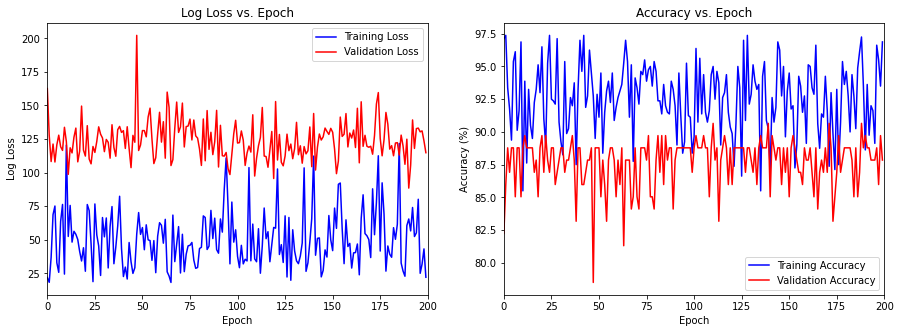

In [ ]:
# Plot loss and accuracy
loop.plot()

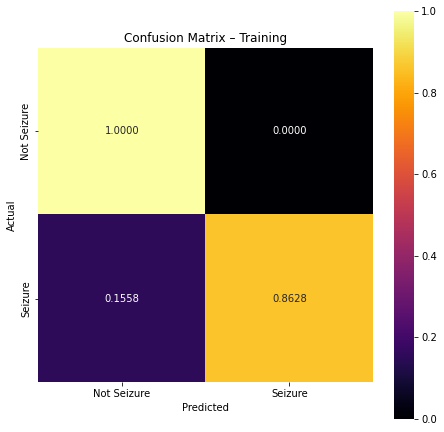

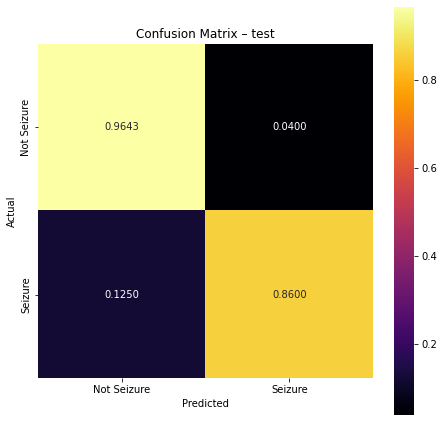

In [ ]:
# Create heatmap
y_pred_train = log_reg_model(x_train_norm, train=False)
y_pred_test = log_reg_model(x_test_norm, train=False)

y_class_train = predict(y_pred_train)
y_class_test = predict(y_pred_test)

con_mat_train = confusion(y_pred=y_class_train, y_true=y_train, class_labels=class_labels, title='Training')
con_mat_test = confusion(y_pred=y_class_test, y_true=y_test, class_labels=class_labels, title='test')

In [ ]:
TN = con_mat_test[0][0]
TP = con_mat_test[1][1]
FN = con_mat_test[1][0]
FP = con_mat_test[0][1]

recall = TP / (TP + FN) # How many seizures were predicted correctly
precision = TP / (TP + FP) # How many predicted seizures were actually positive
f_score = 2 * (recall * precision) / (recall + precision) # Evaluates whether recall and precision are balanced

print(f"Recall = {recall:.3}\nPrecision = {precision:.3}\nF-Score = {f_score:.3}")

Recall = 0.873
Precision = 0.956
F-Score = 0.912
